# Convex hull as diagnostic tool in single-molecule localization microscopy
# Deriving the simulation of localization data with varying intensities

In [1]:
import numpy as np
import locan as lc
import colorcet as cc
import boost_histogram as bh
from sklearn.cluster import DBSCAN
from scipy.stats import gamma, norm, gennorm

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import src.simulations as si
import src.cluster_properties as cp
import src.truncated_gamma_fit as tgf
import src.standard_deviation_determination as stdd
from src.matplotlib_custom import second_axis_log, second_axis

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load experimental data

In [2]:
exp_path = r"experimental_data\CD45_647_7_roi_0.yaml"
roi = lc.Roi.from_yaml(exp_path)
roi.reference.file_path = r"experimental_data\CD45_647_7.txt"
locdata = roi.locdata()
condition = "0 < frame < 15000 and 0 < intensity and local_background < 1200"
locdata = lc.select_by_condition(locdata, condition=condition)
locdata.reduce();

samples_exp = locdata.coordinates

## 1. Intensities and photon counts
The photon counts can be received with a known digital conversion factor f by $N=\frac{I}{f}$, where $I$ is the measured intensity.

In [3]:
intensities = locdata.data["intensity"].to_numpy()
intensity_mean = np.mean(intensities)
intensity_min = np.min(intensities)
intensity_max = np.max(intensities)

factor = 3.38
photon_counts = si.intensity_to_photons(intensities, factor)
photon_counts_mean = np.mean(photon_counts)
photon_counts_min = np.min(photon_counts)
photon_counts_max = np.max(photon_counts)

print(f"The mean intensity is {intensity_mean:.2f}, the minimum intensity is {intensity_min:.2f}, the maximum" +
      f" intensity is {intensity_max:.2f}")
print(f"The mean photon count is {photon_counts_mean:.2f}, the minimum photon count is {photon_counts_min:.2f}, " +
      f" the maximum photon count is {photon_counts_max:.2f}")

The mean intensity is 21738.64, the minimum intensity is 8001.07, the maximum intensity is 142315.00
The mean photon count is 6431.55, the minimum photon count is 2367.18,  the maximum photon count is 42105.03


#### Visualization and fitting of photon counts

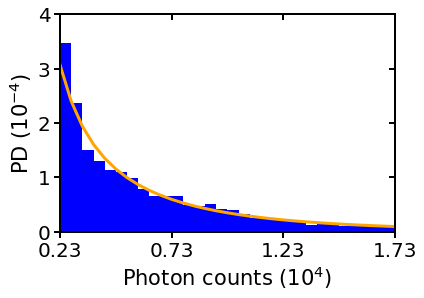

In [4]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))

bins = np.arange(2300, 42300+500, 500)
truncated_data = ax.hist(x=photon_counts, bins=bins, density=True, color="blue")
ax.set_xlim(2300, 17300)
ax.set_xlabel("Photon counts (" + r"$10^{4}$" + ")", fontsize=21)
ax.set_ylabel("PD (" + r"$10^{-4}$" + ")", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
num_ticks_x = 4
ax.xaxis.set_major_locator(ticker.LinearLocator(num_ticks_x))
tick_spacing_y = 0.0001
ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
ax.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.yaxis.get_offset_text().set_visible(False)
ax.xaxis.get_offset_text().set_visible(False)
second_axis(ax, "top", num_ticks=num_ticks_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_ylim(0, 4e-4)

# fit a truncated gamma distribution to the truncated data
trunc_y_data = truncated_data[0]
trunc_x_data = truncated_data[1][:-1]
alpha_values = [3, 1e-3, 10]
beta_values = [1/11000, 1/20000, 1/1000]
lower_bound = 2300

alpha, beta = tgf.trunc_gamma_fit(trunc_y_data, trunc_x_data, alpha_values, beta_values, lower_bound)

ax.plot(trunc_x_data, tgf.pdf_truncated_gamma(trunc_x_data, alpha, beta, lower_bound), c="orange",
        lw=3)

fig.savefig(r"plt_figures\photon_counts_distribution.svg")

The fit of photon counts (orange, truncated gamma distribution) has the following stats:

In [5]:
print("alpha is {:.2e}".format(alpha))
print("beta is {:.2e}".format(beta))
gamma_trunc_mean = tgf.mean_trunc_gamma(alpha, beta, 2360)
gamma_mean = gamma.stats(a=alpha, scale=1/beta, moments="m")
print("the mean of the truncated gamma distribution is {:.2f}".format(gamma_trunc_mean))
print("the mean of the underlying non-truncated gamma distribution is {:.2f}".format(gamma_mean))

alpha is 1.00e-03
beta is 9.72e-05
the mean of the truncated gamma distribution is 7360.81
the mean of the underlying non-truncated gamma distribution is 10.29


The mean of the truncated gamma distribution should be similar to the mean of the experimental data. 
The mean of the underlying non-truncated gamma distribution should later be fed into the simulation.

### Theoretical calculation of the standard deviation 
The localization precision is calculated with $\sigma = \sqrt{\frac{\sigma_{a}^2}{N}(1 + 4 \tau + \sqrt{\frac{2 \tau}{1+4\tau}}}$ with $\sigma_{a}^2 = \sigma_{PSF}^2+\frac{a^2}{12}$ and $\tau = \frac{2\pi\sigma_{a}^2b}{Na^2}$\
$\sigma_{PSF}$ is the standard deviation of the point spread function, i.e. $\sigma_{PSF} = \frac{FWHM}{2\sqrt{2\ln{2}}}$\
$a$ is the pixel size\
$b$ is the background photon count per pixel\
$N$ is the photon count of the localization

In [6]:
psf_std = si.fwhm_to_std(480)  
photons_background = 148  # per pixel
pixel_size = 134

# due to the use of a EMCCD camera, a factor of sqrt(2) has to be included (excess noise)
computed_cluster_stds = si.compute_cluster_std(psf_std, pixel_size, photon_counts, photons_background, emccd=True)

print(f"The computed mean localization precision of experimental data is {np.mean(computed_cluster_stds):.2f}")

The computed mean localization precision of experimental data is 8.13


## Fitting of position deltas
The position deltas are the differences in x or y coordinate of an offspring to its parent point, i.e. of a localization to its true fluorophore position.

The normal distribution can be used to fit the simulated data of constant localization precision. The resulting standard deviation resembles the localization precision.
In the case of the simulation of varying localization precisions, the generalized normal distribution is better suited.

#### Varying localization precision

In [7]:
photon_counts_mean = gamma_mean  # the mean of the non-truncated distribution is required
make_param = dict(parent_intensity=1e-5, lower_limit=-15300, upper_limit=15300, cluster_mu=9,
                 seed=np.random.default_rng(100), gamma_a=alpha, photons_min=photon_counts_min,
                 photons_mean=photon_counts_mean, photons_background=photons_background, psf_std=psf_std, 
                 pixel_size=pixel_size)
samples, labels, parent_samples, mean_cluster_std, cluster_stds, _ = si.make_std_vary(**make_param)

distribution_spatial_coordinates = []
for i, parent in enumerate(parent_samples):
    indices = np.where(labels == i)
    samples_of_parent = samples[indices]
    position_delta = [parent-sample_of_parent for sample_of_parent in samples_of_parent]
    distribution_spatial_coordinates.extend(position_delta)
distribution_spatial_coordinates = np.concatenate(distribution_spatial_coordinates)

#### Constant localization precision

In [8]:
make_param2 = dict(parent_intensity=1e-5, lower_limit=-15300, upper_limit=15300, cluster_mu=9,
                  seed=np.random.default_rng(100), cluster_std=mean_cluster_std)
samples2, labels2, parent_samples2 = si.make_dstorm(**make_param2)

distribution_spatial_coordinates2 = []
for i, parent in enumerate(parent_samples2):
    indices = np.where(labels2 == i)
    samples_of_parent = samples2[indices]
    position_delta = [parent-sample_of_parent for sample_of_parent in samples_of_parent]
    distribution_spatial_coordinates2.extend(position_delta)
distribution_spatial_coordinates2 = np.concatenate(distribution_spatial_coordinates2)

In [9]:
loc1, scale1 = norm.fit(distribution_spatial_coordinates)
loc2, scale2 = norm.fit(distribution_spatial_coordinates2)

print("The mean localization precision was {:.2f}.".format(mean_cluster_std))
print("The norm fit of the constant localization precision is {:.2f}".format(scale2))
print("The norm fit of the varying localization precision is {:.2f}".format(scale1))

beta, loc3, scale3 = gennorm.fit(distribution_spatial_coordinates)
print(f"The parameters of the generalized normal distribution (used to fit the varying localization precision)" +
      f" are beta = {beta:.3f}, loc = {loc3:.3f}, scale = {scale3:.3f}.")

The mean localization precision was 7.63.
The norm fit of the constant localization precision is 7.63
The norm fit of the varying localization precision is 8.32
The parameters of the generalized normal distribution (used to fit the varying localization precision) are beta = 1.170, loc = 0.008, scale = 7.419.


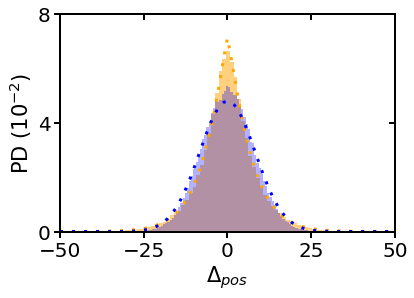

In [10]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots()
x = np.arange(-50, 51, 1)
ax.hist(distribution_spatial_coordinates, density=True, bins=100, color="orange", alpha=0.5);
ax.plot(x, gennorm.pdf(x, beta, scale=scale3), color="orange", ls=(0, (1, 3)), lw=3)
ax.hist(distribution_spatial_coordinates2, density=True, bins=100, color="blue", alpha=0.3);
ax.plot(x, norm.pdf(x, scale=scale1), color="blue", ls=(0, (1, 3)), lw=3)
ax.set_xlim(-50, 50)
num_ticks_x = 5
ax.xaxis.set_major_locator(ticker.LinearLocator(num_ticks_x))
tick_spacing_y = 0.04
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.yaxis.get_offset_text().set_visible(False)
ax.ticklabel_format(style="sci", axis="y", scilimits=(0,0))
second_axis(ax, "top", num_ticks=num_ticks_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_ylim(0, 0.08)
ax.tick_params(labelsize=20, width=2, length=6)
ax.set_ylabel("PD (" + r"$10^{-2}$" + ")", fontsize=21)
ax.set_xlabel("$\u0394_{pos}$", fontsize=21)

fig.savefig(r"plt_figures\position_deltas.svg")

## Localization precision distribution
Since the intensities / photons are gamma distributed and the localization precision is connected via $\frac{1}{\sqrt{photons}}$, the resulting distribution of localization precisions follows an inverse Nakagami-m (INK) disitribution. The highest value corresponds to the lowest photon count or intensity.

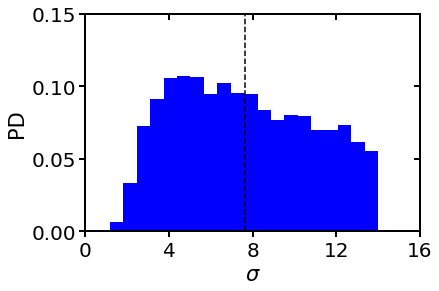

In [11]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(x=cluster_stds, bins=20, density=True, color="blue")
ax.axvline(x=mean_cluster_std, color="k", ls="--")
ax.set_xlim(0, 16)
ax.set_xlabel(r"$\sigma$", fontsize=21)
ax.set_ylabel("PD", fontsize=21)
ax.tick_params(labelsize=20, width=2, length=6)
num_ticks_x = 5
ax.xaxis.set_major_locator(ticker.LinearLocator(num_ticks_x))
tick_spacing_y = 0.05
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
second_axis(ax, "top", num_ticks=num_ticks_x)
second_axis(ax, "right", tick_spacing_y)
ax.set_ylim(0, 0.15)

fig.savefig(r"plt_figures\std_distribution_INK.svg")

## 2D Histograms of the area of the convex hull per n

### Experimental data

In [12]:
clust_labels_exp = DBSCAN(eps=25, min_samples=3).fit_predict(samples_exp)
_, sample_count_exp, area_chs_exp, _ = cp.cluster_property(clust_labels_exp, samples_exp)
experimental_data = np.concatenate(([sample_count_exp], [area_chs_exp]))  

### Simulation with varying localization precision

In [13]:
photon_counts_mean = gamma_mean  # the mean of the non-truncated distribution is required
sim_param = dict(parent_intensity=1e-5, lower_limit=-5300, upper_limit=5300, cluster_mu=9, min_samples=3,
                 seed=np.random.default_rng(100), gamma_a=alpha, photons_min=photon_counts_min,
                 photons_mean=photon_counts_mean, photons_background=photons_background, psf_std=psf_std, 
                 pixel_size=pixel_size, emccd=True)  # the limits are chosen such that the number of clusters is 
# similar to experimental cluster counts

samples_vary, labels_vary, _, mean_cluster_std, cluster_stds, photons, _ = si.sim_std_vary(**sim_param)
print(f"The mean localization precision is {mean_cluster_std:.2f}")
_, sample_count_vary, area_chs_vary, _ = cp.cluster_property(labels_vary, samples_vary)

varying_cluster_std = np.concatenate(([sample_count_vary], [area_chs_vary]))  # for 2D histogram

The mean localization precision is 7.59


### Simulation with constant localization precision

In [14]:
sim_param = dict(parent_intensity=1e-5, lower_limit=-5300, upper_limit=5300, cluster_mu=9, 
                 cluster_std=mean_cluster_std, seed=np.random.default_rng(100), min_samples=3)

samples_const, labels_const, _ = si.sim_dstorm(**sim_param)
_, sample_count_const, area_chs_const, _ = cp.cluster_property(labels_const, samples_const)

constant_cluster_std = np.concatenate(([sample_count_const], [area_chs_const]))  # for 2D histogram

Top left: Experimental data (CD45)\
Bottom left: Simulation with varying localization precisions\
Top right: Simulation with constant localization precision

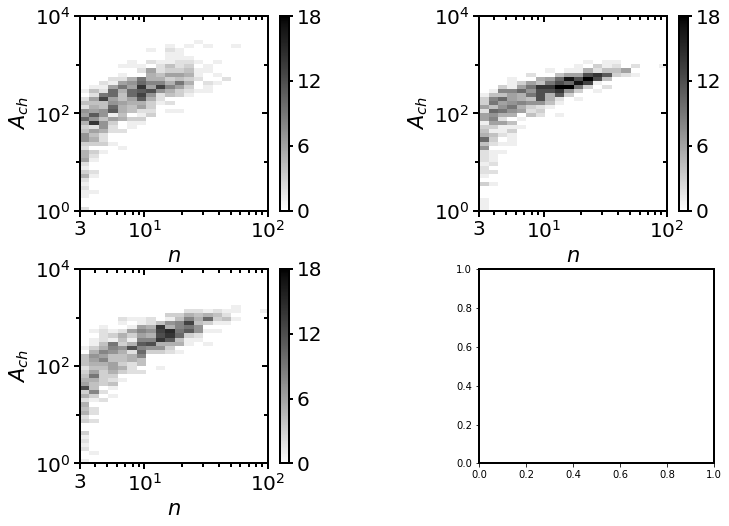

In [15]:
rcParams["axes.linewidth"] = 2
fig, ax = plt.subplots(2, 2, figsize=(11.36, 7.1))
fig.subplots_adjust(hspace=0.3, wspace=0.7, top=1)
axes = bh.axis.AxesTuple((
    bh.axis.Regular(20, 3, 103, transform=bh.axis.transform.log),
    bh.axis.Regular(50, 1, 15000, transform=bh.axis.transform.log)
))
histogram = bh.Histogram(*axes)
y_1 = [experimental_data, varying_cluster_std, constant_cluster_std]
vmax = [18, 18, 18]
cbar_spacing = [6, 6, 6]
axeses = np.concatenate((ax[:, 0], ax[:, 1]))


for i, axis in enumerate(axeses):
    if i == 3:
        continue
    histogram.reset()
    histogram.fill(*y_1[i])
    mesh = axis.pcolormesh(*histogram.axes.edges.T, histogram.view().T, vmin=0, vmax=vmax[i], 
                           cmap=cc.m_gray.reversed(), zorder=0)
    cbar = fig.colorbar(mesh, ax=axis)
    cbar.ax.yaxis.set_major_locator(ticker.MultipleLocator(cbar_spacing[i]))
    cbar.ax.tick_params(width=2, length=4, labelsize=20)
    axis.set_xscale("log")
    axis.set_yscale("log")
    axis.set_ylabel(r"$A_{ch}$", fontsize=21)
    axis.set_xlabel(r"$n$", fontsize=21)
    tick_spacing_x = 10
    axis.xaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_x))
    tick_spacing_y = 100
    axis.yaxis.set_major_locator(ticker.LogLocator(base=tick_spacing_y))
    axis.tick_params(labelsize=20, width=2, length=6)
    axis.yaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(1., 10.), base=10))
    axis.xaxis.set_minor_locator(ticker.LogLocator(numticks=10, subs=(2., 3., 4., 5., 6., 7., 8., 9.), base=10))
    axis.tick_params(which="minor", width=2, length=4, labelleft=False, left=True)
    second_axis_log(axis, "top", tick_spacing_x)
    second_axis_log(axis, "right", tick_spacing_y)
    axis.set_ylim(1, 1e4)
    xtick = axis.get_xticks()
    np.append(xtick, [3])
    xtick[-1] = 3
    labels = [item.get_text() for item in axis.get_xticklabels()]
    for i in range(len(xtick)):
        l = int(np.log10(xtick[i]))
        labels[i] = r"$10^{}$".format(l)
    labels[-1] = "3"
    axis.set_xticks(xtick)
    axis.set_xticklabels(labels)
    axis.set_xlim(3, 1e2)

fig.savefig(r"plt_figures\simulation_exp_data_2d_histograms.svg")